In [1]:
# ruff: noqa
import argparse
import logging
import re
import sys
from pathlib import Path

import anndata2ri
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import scanpy as sc
from rpy2.robjects.conversion import localconverter

plt.rcParams["font.family"] = (
    "Arial" if "Arial" in [f.name for f in fm.fontManager.ttflist] else "sans-serif"
)
plt.rcParams["font.weight"] = "normal"

sys.path.insert(1, "/dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark")
from cellseg_benchmark.dea_utils import prepare_adata_for_rpy2, subset_by_brain_region


def get_args(test_args=None):
    p = argparse.ArgumentParser(description="Run MAST single-cell-based DEA")
    p.add_argument("cohort", help="Cohort name, e.g. foxf2")
    p.add_argument(
        "seg_method", help="Segmentation method, e.g. Cellpose_1_nuclei_model"
    )
    p.add_argument(
        "--sample_key", default="sample", help="obs column for donor/sample ID"
    )
    p.add_argument(
        "--subset_key",
        default="cell_type",
        help="obs column used to subset data (e.g. cell_type, cluster, region)",
    )
    p.add_argument(
        "--subset_values",
        nargs="+",
        default=None,
        help="Values of subset_key to process (default: all unique values)",
    )
    p.add_argument(
        "--condition_key",
        default="genotype",
        help="obs column for condition (e.g. genotype)",
    )
    p.add_argument(
        "--batch_key",
        default="slide",
        help="optional batch key for inclusion as covariate (default: slide)",
    )
    p.add_argument("--ref", default="WT", help="Reference group (default: WT)")
    p.add_argument(
        "--test_groups",
        nargs="+",
        default=None,
        help="Groups to test vs reference (default: all groups in condition_key except --ref)",
    )
    p.add_argument(
        "--brain_region_subset",
        default=None,
        help="Alias (cortex, hippocampus, white_matter, grey_matter) or comma-separated raw labels.",
    )
    p.add_argument("--overwrite", default=False, help="Overwrite cache?")

    if test_args is not None:
        return p.parse_args(test_args)
    else:
        return p.parse_args()

In [2]:
# Simulate CLI arguments inside Jupyter
args = get_args(
    [
        "aging",
        "Cellpose_1_nuclei_model",
        "--sample_key",
        "sample",
        "--subset_key",
        "cell_type",
        "--condition_key",
        "condition",
        "--batch_key",
        "slide",
        "--ref",
        "WT_3",
        "--brain_region_subset",
        "grey_matter",
    ]
)

In [3]:
# Simulate CLI arguments inside Jupyter
args = get_args(
    [
        "foxf2",
        "Cellpose_1_nuclei_model",
        "--sample_key",
        "sample",
        "--subset_key",
        "cell_type",
        "--condition_key",
        "genotype",
        "--batch_key",
        "slide",
        "--ref",
        "WT",
        "--brain_region_subset",
        "white_matter",
    ]
)

In [4]:
# Simulate CLI arguments inside Jupyter
args = get_args(
    [
        "aging",
        "Proseg_3D_Cellpose_1_nuclei_model",
        "--sample_key",
        "sample",
        "--subset_key",
        "cell_type",
        "--condition_key",
        "condition",
        "--batch_key",
        "slide",
        "--ref",
        "WT_3",
        # "--brain_region_subset", "grey_matter"
    ]
)

In [5]:
args

Namespace(cohort='aging', seg_method='Proseg_3D_Cellpose_1_nuclei_model', sample_key='sample', subset_key='cell_type', subset_values=None, condition_key='condition', batch_key='slide', ref='WT_3', test_groups=None, brain_region_subset=None, overwrite=False)

In [6]:
# Logger setup
logger = logging.getLogger("dea-MAST")
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s]: %(message)s"))
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    logger.propagate = False
# rcb.logger.handlers = logger.handlers
# rcb.consolewrite_print = rcb.consolewrite_warnerror = lambda x: logger.info(f"R: {x.strip()}")

rcb.logger.handlers = logger.handlers
rcb.consolewrite_print = lambda x: logger.debug(f"R: {x.strip()}")
rcb.consolewrite_error = lambda x: (_ for _ in ()).throw(RRuntimeError(x.strip()))  # noqa: F821
rcb.consolewrite_message = lambda x: logger.info(f"R: {x.strip()}")
rcb.consolewrite_warn = lambda x: (
    logger.warning if x.lstrip().lower().startswith("warning") else logger.info
)(f"R: {x.strip()}")
setattr(rcb, "consolewrite_warnerror", rcb.consolewrite_warn)

In [7]:
# R setup
conv = ro.default_converter + ro.pandas2ri.converter + anndata2ri.converter
r_script = Path(sys.path[1]) / "cellseg_benchmark" / "dea_utils.r"
ro.r["source"](str(r_script))
mast_run_cached = ro.globalenv["mast_run_cached"]

In [8]:
%load_ext rpy2.ipython

In [9]:
base_path = Path("/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark")
method_path = base_path / "analysis" / args.cohort / args.seg_method
output_dir = method_path / "dea"
output_dir.mkdir(parents=True, exist_ok=True)

cache_dir = output_dir / "mast_dea_cache"
cache_dir.mkdir(parents=True, exist_ok=True)
logger.info(f"Using cache directory: {cache_dir}")

2025-11-23 17:15:12,195 [INFO]: Using cache directory: /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/analysis/aging/Proseg_3D_Cellpose_1_nuclei_model/dea/mast_dea_cache


In [10]:
logger.info("Loading integrated AnnData...")
adata = sc.read_h5ad(method_path / "adatas" / "adata_integrated.h5ad.gz")
adata.obs["cell_type"] = adata.obs["cell_type_revised"]

2025-11-23 17:15:12,203 [INFO]: Loading integrated AnnData...


In [11]:
# re-group cell types
adata.obs["cell_type"] = (
    adata.obs["cell_type"]
    .astype(str)
    .replace(
        {
            "Tanycytes": "Ependymal",
            "Astroependymal": "Astrocytes",
            "Neurons-Glyc-Gaba": "Neurons-Other",
        }
    )
    .astype("category")
)

In [12]:
adata.obs["cell_type"].value_counts()

cell_type
Neurons-Glut                129550
Oligodendrocytes            121410
Neurons-Dopa                 80585
Astrocytes                   72012
ECs                          46563
Neurons-Granule-Immature     45584
Neurons-Other                43680
Undefined                    30909
Microglia                    27096
OPCs                         21142
Pericytes                    14331
VLMCs                         9762
SMCs                          7320
Ependymal                     6302
Choroid-Plexus                5873
Neurons-Gaba                  3423
BAMs                          1512
Immune-Other                   878
ABCs                            22
Name: count, dtype: int64

In [13]:
# Clean up group names for R conversion
adata.obs[args.subset_key] = [
    key.replace(" ", "_")
    .replace("-", "_")
    .replace("/", "_")
    .replace("+", "")
    .replace("(", "")
    .replace(")", "")
    if not pd.isna(key)
    else key
    for key in adata.obs[args.subset_key]
]
for col in [args.condition_key, args.sample_key, args.subset_key]:
    adata.obs[col] = adata.obs[col].astype("category")

In [14]:
if args.test_groups is None:
    groups = adata.obs[args.condition_key].dropna().unique().tolist()
    args.test_groups = [g for g in groups if g != args.ref]
    msg = (
        f"Test groups inferred from '{args.condition_key}': {', '.join(map(str, args.test_groups))}"
        if args.test_groups
        else f"No test groups found different from ref '{args.ref}' under '{args.condition_key}'."
    )
    logger.info(msg)
# sample overview
if args.subset_values is None:
    groups_to_process = sorted(adata.obs[args.subset_key].unique())
else:
    groups_to_process = args.subset_values
for cond, df in adata.obs.groupby(args.condition_key, observed=True):
    samples = df[args.sample_key].unique()
    logger.info(f"{cond}: {len(samples)} samples → {', '.join(samples)}")

2025-11-23 17:16:23,159 [INFO]: Test groups inferred from 'condition': WT_6, WT_12, WT_18, WT_24
2025-11-23 17:16:23,333 [INFO]: WT_3: 3 samples → aging_s8_r1, aging_s10_r1, aging_s10_r2
2025-11-23 17:16:23,336 [INFO]: WT_6: 3 samples → aging_s1_r0, aging_s5_r1, aging_s7_r2
2025-11-23 17:16:23,338 [INFO]: WT_12: 3 samples → aging_s5_r2, aging_s8_r0, aging_s12_r0
2025-11-23 17:16:23,340 [INFO]: WT_18: 3 samples → aging_s6_r0, aging_s8_r2, aging_s11_r0
2025-11-23 17:16:23,343 [INFO]: WT_24: 3 samples → aging_s10_r0, aging_s11_r1, aging_s11_r2


In [15]:
args.test_groups

['WT_6', 'WT_12', 'WT_18', 'WT_24']

In [16]:
if args.batch_key and args.batch_key not in adata.obs.columns:
    logger.warning(
        f"Batch column '{args.batch_key}' was not found in adata.obs "
        "or is invalid. Continuing **without** a batch covariate."
    )
    args.batch_key = None

In [17]:
adata.X = adata.layers["volume_log1p_norm"].copy()

In [18]:
# brain region subsetting (optional)
adata, chosen_brain_regions = subset_by_brain_region(
    adata, method_path, args.brain_region_subset, logger
)
if chosen_brain_regions:
    from cellseg_benchmark.adata_utils import plot_spatial_multiplot

    plot_spatial_multiplot(adata, "brain_region", size=0.2, figsize_per_ax=2)

In [19]:
adata = prepare_adata_for_rpy2(adata, key=args.subset_key)

In [20]:
del adata.varm
adata.obsm = {"spatial": adata.obsm["spatial"]}
del adata.obsp
adata.uns["pca"]["params"].pop("mask_var", None)

In [21]:
adata_dict = {}
unique_groups = adata.obs[args.subset_key].unique().tolist()
for key in unique_groups:
    tmp = adata[adata.obs[args.subset_key] == key].copy()
    adata_dict[key] = tmp
adata_dict["all"] = adata.copy()

In [22]:
adata_dict.keys()

dict_keys(['VLMCs', 'BAMs', 'SMCs', 'Neurons_Dopa', 'OPCs', 'Astrocytes', 'Microglia', 'ECs', 'Pericytes', 'Oligodendrocytes', 'Neurons_Gaba', 'Neurons_Glut', 'Undefined', 'Neurons_Other', 'Ependymal', 'Choroid_Plexus', 'Neurons_Granule_Immature', 'Immune_Other', 'ABCs', 'all'])

In [23]:
del adata

In [24]:
# run loop

In [25]:
args.ref

'WT_3'

In [26]:
# args.test_groups = ["ECKO"]
# args.test_groups = ["ECKO", "PCKO", "GLKO"]
args.test_groups

['WT_6', 'WT_12', 'WT_18', 'WT_24']

In [27]:
args.overwrite

False

In [28]:
args.sample_random_effects = True
args.sample_random_effects

True

In [29]:
args.brain_region_subset

[Jin 2025 Nature](https://www.nature.com/articles/s41586-024-08350-8#Sec16:~:text=To%20decrease%20running%20time%2C%20for%20large%20subclasses%2C%20we%20subsampled%20them%20to%20a%20maximum%20of%202%2C000%20cells%20per%20age) subsampled "large subclasses to a maximum of 2,000 cells" per condition to decrease runtime (using MAST).


In [30]:
args.max_cells_per_condition = 5_000
# args.max_cells_per_condition = 10_000
# args.max_cells_per_condition = 2_500
args.max_cells_per_condition

5000

In [31]:
%%R -o n # noqa: F821
## Parallel setup
n <- as.integer(Sys.getenv("SLURM_CPUS_PER_TASK", unset = NA))
if (is.na(n)) n <- parallel::detectCores(logical = FALSE)
if (is.na(n)) n <- parallel::detectCores()
n <- max(1L, n - 1L)
n

In [32]:
n

array([9], dtype=int32)

In [33]:
cache_dir

PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/analysis/aging/Proseg_3D_Cellpose_1_nuclei_model/dea/mast_dea_cache')

In [ ]:
# loop over cell types
all_degs = {}
with localconverter(conv):
    for group_i, adata_tmp in adata_dict.items():
        logger.info(f"---> Processing {group_i}...")
        levels = (
            adata_tmp.obs[args.condition_key].dropna().astype(str).unique().tolist()
        )
        if args.ref not in levels or len(levels) < 2:
            logger.info(f"    Skip {group_i}: ref missing or <2 conditions ({levels}).")
            continue
        tests = [
            g for g in (args.test_groups or levels) if g in levels and g != args.ref
        ]
        if not tests:
            logger.info(f"    Skip {group_i}: no tests vs ref ({levels}).")
            continue
        res_r = mast_run_cached(
            adata=adata_tmp,
            group_i=group_i,
            test_groups=ro.vectors.StrVector(tests),
            ref_group=args.ref,
            condition_col=args.condition_key,
            sample_col=args.sample_key,
            batch_col=(args.batch_key if args.batch_key else ro.NULL),
            cache_dir=str(cache_dir),
            overwrite=bool(args.overwrite),
            clear_cache=bool(False),
            sample_random_effects=bool(args.sample_random_effects),
            max_cells_per_condition=int(args.max_cells_per_condition),
            brain_region_subset=(
                args.brain_region_subset.strip()
                if args.brain_region_subset
                else ro.NULL
            ),
        )

        if res_r is ro.NULL:
            logger.info(
                f"    Skip {group_i}: MAST model failed or was skipped in R (see R log)."
            )
            continue
        all_degs[group_i] = ro.conversion.rpy2py(res_r)

In [ ]:
all_degs["ECs"]

In [ ]:
logger.info("Format output table...")
collapsed_df = pd.concat(
    [pd.DataFrame(v).assign(subset=k) for k, v in all_degs.items()], ignore_index=True
).drop(columns=["result_id", "subset_group"], errors="ignore")

In [ ]:
from cellseg_benchmark.dea_utils import (
    add_ensembl_id,
    add_group_sample_counts,
    safe_sheet,
)

In [ ]:
collapsed_df

In [ ]:
# Add sample/group counts
collapsed_df = add_group_sample_counts(
    collapsed_df,
    adata_dict,
    condition_key=args.condition_key,
    sample_key=args.sample_key,
    ref=args.ref,
    test_groups=args.test_groups,
    subset_group="subset",
)

if args.brain_region_subset:
    collapsed_df["brain_region_subset"] = args.brain_region_subset.strip()

collapsed_df = collapsed_df.set_index("gene")
collapsed_df.insert(collapsed_df.columns.get_loc("FC"), "gene", collapsed_df.index)
collapsed_df["method"] = "MAST-RE" if args.sample_random_effects else "MAST"

order = [
    "subset",
    *(["brain_region_subset"] if "brain_region_subset" in collapsed_df.columns else []),
    "gene",
    "FC",
    "log2FC",
    "PValue",
    "FDR",
    "wald",
    "method",
    "model",
    "test_group",
    "ref",
    "test",
]
cols = [c for c in order if c in collapsed_df.columns] + [
    c for c in collapsed_df.columns if c not in order
]
collapsed_df = collapsed_df.loc[:, cols]

logger.info("Add ensembl gene ids...")
collapsed_df = add_ensembl_id(collapsed_df, logger=logger)

In [ ]:
collapsed_df["method"].unique()[0]

In [ ]:
collapsed_df[collapsed_df["subset"] == "ECs"].head()

In [ ]:
args.overwrite

In [ ]:
logger.info("Export table(s)...")
subset_key_clean = re.sub(r"[_-]", "", args.subset_key)
assert collapsed_df["method"].nunique() == 1, (
    f"Expected one unique method in output table, found {collapsed_df['method'].unique().tolist()}"
)

title_num = (
    f"{(args.max_cells_per_condition / 1e6):.1f}".rstrip("0").rstrip(".") + "M"
    if args.max_cells_per_condition >= 1e6
    else f"{(args.max_cells_per_condition / 1e3):.1f}".rstrip("0").rstrip(".") + "k"
    if args.max_cells_per_condition >= 1e3
    else str(args.max_cells_per_condition)
)
method_name = collapsed_df["method"].unique()[0]
br_tag = (
    f"_Subset-{args.brain_region_subset.strip()}" if args.brain_region_subset else ""
)
name = f"{args.cohort}-by-{subset_key_clean}_{method_name}_{title_num}{br_tag}"

In [ ]:
name

In [ ]:
for (method, test), df_mt in collapsed_df.groupby(["method", "test"]):
    df_mt = df_mt.loc[:, df_mt.notna().any()]  # drop all-NaN cols
    safe_test = re.sub(r"[^\w.-]+", "_", str(test))  # filename-safe
    xlsx = output_dir / f"{name}_{safe_test}.xlsx"
    if xlsx.exists() and not args.overwrite:
        logger.info(f"  Exists, skip: {xlsx}")
        continue
    used = set()
    with pd.ExcelWriter(xlsx, engine="xlsxwriter") as writer:
        for gid, g in df_mt.groupby("subset", sort=True):
            g.sort_values("PValue").to_excel(
                writer, sheet_name=safe_sheet(gid, used), index=False
            )
    logger.info(f"  Wrote: {xlsx}")

logger.info("Done.")

In [ ]:
############### get mean expression per sample

In [30]:
def mean_expr_per_sample_celltype(
    adata, layer=None, sample_key="sample", celltype_key="cell_type", condition_key=None
):
    from scipy import sparse

    out = []
    for (sample, ctype), idx in adata.obs.groupby(
        [sample_key, celltype_key], observed=True
    ).groups.items():
        ad_sub = adata[idx, :]
        Xg = (
            ad_sub.layers[layer]
            if (layer is not None and layer in ad_sub.layers)
            else ad_sub.X
        )
        m = Xg.mean(axis=0)
        means = m.A1 if sparse.issparse(Xg) else np.asarray(m).ravel()
        cond = ad_sub.obs[condition_key].iloc[0] if condition_key else None
        out.append(
            pd.DataFrame(
                {
                    "sample": sample,
                    "cell_type": ctype,
                    "condition": cond,
                    "gene": ad_sub.var_names.to_numpy(),
                    "mean_expr": means,
                }
            )
        )
    cols = (
        ["sample", "cell_type", "condition", "gene", "mean_expr"]
        if condition_key
        else ["sample", "cell_type", "gene", "mean_expr"]
    )
    return (
        pd.concat(out, ignore_index=True)[cols] if out else pd.DataFrame(columns=cols)
    )

In [34]:
group_i = next(iter(adata_dict.keys()))
group_i = "ECs"
adata_tmp = adata_dict[group_i]

In [35]:
group_i = next(iter(adata_dict.keys()))
group_i = "ECs"
adata_tmp = adata_dict[group_i]

In [37]:
means_df = mean_expr_per_sample_celltype(
    adata_tmp, layer="volume_log1p_norm", sample_key="sample", condition_key="genotype"
)

In [38]:
means_df[(means_df.cell_type == "ECs") & (means_df.gene == "Foxf2")].sort_values(
    "mean_expr", ascending=False
)

,sample,cell_type,condition,gene,mean_expr
5183,foxf2_s6_r2,ECs,WT,Foxf2,0.689619
5683,foxf2_s7_r0,ECs,WT,Foxf2,0.585161
683,foxf2_s1_r1,ECs,WT,Foxf2,0.557673
2183,foxf2_s4_r0,ECs,PCKO,Foxf2,0.546170
1683,foxf2_s2_r2,ECs,PCKO,Foxf2,0.496530
1183,foxf2_s2_r1,ECs,WT,Foxf2,0.478933
3183,foxf2_s5_r0,ECs,PCKO,Foxf2,0.440119
4183,foxf2_s6_r0,ECs,GLKO,Foxf2,0.112340
2683,foxf2_s4_r1,ECs,ECKO,Foxf2,0.111407
6183,foxf2_s7_r1,ECs,GLKO,Foxf2,0.090314


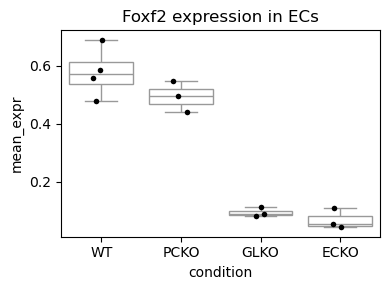

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

cell_type, gene = "ECs", "Foxf2"
d = means_df.query(f'cell_type == "{cell_type}" and gene == "{gene}"')

order = d.groupby("condition")["mean_expr"].median().sort_values(ascending=False).index

plt.figure(figsize=(4, 3))
sns.boxplot(
    data=d, x="condition", y="mean_expr", order=order, color="white", fliersize=0
)
sns.stripplot(
    data=d,
    x="condition",
    y="mean_expr",
    order=order,
    color="black",
    size=4,
    jitter=True,
)
plt.title(f"{gene} expression in {cell_type}")
plt.tight_layout()

In [66]:
############## dissect loop

In [33]:
group_i = next(iter(adata_dict.keys()))
group_i = "ECs"
adata_tmp = adata_dict[group_i]

In [34]:
args.max_cells_per_condition = 5_000
args.sample_random_effects = True

In [35]:
logger.info(f"---> Processing {group_i}...")

2025-11-21 16:38:29,824 [INFO]: ---> Processing ECs...


In [36]:
args.test_groups = ["ECKO", "PCKO", "GLKO"]
args.test_groups = ["ECKO"]

In [37]:
args.test_groups

['ECKO']

In [38]:
args.overwrite = False

In [39]:
args.batch_key

'slide'

In [40]:
# %%R
# parallel::setDefaultCluster(NULL)

In [41]:
# create temp cache dir
cache_dir2 = cache_dir / "temp"
cache_dir2.mkdir(parents=True, exist_ok=True)
cache_dir2

PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/analysis/aging/Proseg_3D_Cellpose_1_nuclei_model/dea/mast_dea_cache/temp')

In [42]:
# note: increase memory for "all"

In [43]:
group_i

'ECs'

In [ ]:
# run single cell type
with localconverter(conv):
    logger.info(f"---> Processing {group_i}...")
    res_r = ro.r["mast_run_cached"](
        adata=adata_tmp,
        group_i=group_i,
        test_groups=ro.vectors.StrVector(list(args.test_groups)),
        ref_group=args.ref,
        condition_col=args.condition_key,
        sample_col=args.sample_key,
        batch_col=(args.batch_key if args.batch_key else ro.NULL),
        cache_dir=str(cache_dir),
        overwrite=bool(args.overwrite),
        clear_cache=bool(False),
        sample_random_effects=bool(args.sample_random_effects),
        max_cells_per_condition=int(args.max_cells_per_condition),
    )

In [38]:
all_degs = {}
if res_r is not ro.NULL:
    all_degs[group_i] = ro.conversion.rpy2py(res_r)

In [40]:
all_degs["ECs"]

rec.array([('Cldn5', 1.14630612e-73, -0.37281502, -18.43331056, 3.59940120e-71, 'ECs', 'MAST-FE', 'WT_6vsWT_3', 'WT_6', 'WT_3', 0.77227414, '~ condition + slide'),
           ('Cdkn1a', 1.20529706e-61, -0.28497313, -13.18069451, 1.89231638e-59, 'ECs', 'MAST-FE', 'WT_6vsWT_3', 'WT_6', 'WT_3', 0.8207569 , '~ condition + slide'),
           ('Cx3cl1', 7.04803832e-60, -0.33396014, -15.99008157, 7.37694678e-58, 'ECs', 'MAST-FE', 'WT_6vsWT_3', 'WT_6', 'WT_3', 0.79335577, '~ condition + slide'),
           ...,
           ('Clec12a', 6.74263021e-11,  0.00292097,   2.60203643, 6.78585220e-11, 'ECs', 'MAST-FE', 'WT_24vsWT_3', 'WT_24', 'WT_3', 1.00202671, '~ condition + slide'),
           ('Myh11', 1.34947651e-07,  0.01672051,   4.3998321 , 1.35378794e-07, 'ECs', 'MAST-FE', 'WT_24vsWT_3', 'WT_24', 'WT_3', 1.0116572 , '~ condition + slide'),
           ('Meg3', 1.94330009e-07,  0.03378601,   1.96392223, 1.94330009e-07, 'ECs', 'MAST-FE', 'WT_24vsWT_3', 'WT_24', 'WT_3', 1.02369505, '~ condition + 

In [34]:
# dissect mast_run_cached R function

In [45]:
# Restore R prints and messages to appear in Jupyter output again
import importlib

import rpy2.rinterface_lib.callbacks as rcb

_keep_warn, _keep_error = rcb.consolewrite_warn, rcb.consolewrite_error
rcb = importlib.reload(rcb)
rcb.consolewrite_warn, rcb.consolewrite_error = _keep_warn, _keep_error

In [50]:
adata_tmp.var.dtypes

gene            object
total_count     uint32
lambda_bg_0    float32
lambda_bg_1    float32
lambda_bg_2    float32
lambda_bg_3    float32
lambda_bg_4    float32
lambda_bg_5    float32
lambda_bg_6    float32
n_cells          int64
dtype: object

In [ ]:
with localconverter(conv):
    ro.globalenv["adata"] = adata_tmp
    ro.globalenv["group_i"] = group_i
    ro.globalenv["test_groups"] = ro.vectors.StrVector(list(args.test_groups))
    ro.globalenv["ref_group"] = args.ref
    ro.globalenv["condition_col"] = args.condition_key
    ro.globalenv["sample_col"] = args.sample_key
    ro.globalenv["batch_col"] = args.batch_key if args.batch_key else ro.NULL
    ro.globalenv["cache_dir"] = str(cache_dir2)
    ro.globalenv["overwrite"] = bool(args.overwrite)
    ro.globalenv["clear_cache"] = False
    ro.globalenv["sample_random_effects"] = bool(args.sample_random_effects)
    ro.globalenv["max_cells_per_condition"] = int(args.max_cells_per_condition)

In [ ]:
%%R
adata

In [38]:
%%R
mode_tag <- if (isTRUE(sample_random_effects)) "RE" else "FE"
## interpret cap
unlimited_cap <- is.null(max_cells_per_condition) ||
                 !is.finite(max_cells_per_condition)
cap_val <- if (unlimited_cap) "ALL" else as.integer(max_cells_per_condition)
## parallel setup
n <- as.integer(Sys.getenv("SLURM_CPUS_PER_TASK", unset = NA))
if (is.na(n)) n <- parallel::detectCores(logical = FALSE)
if (is.na(n)) n <- parallel::detectCores()
n <- max(1L, n - 1L)
options(mc.cores = n)
Sys.setenv(OMP_NUM_THREADS="1", MKL_NUM_THREADS="1",
           OPENBLAS_NUM_THREADS="1", BLIS_NUM_THREADS="1")
data.table::setDTthreads(1)

In [39]:
%%R
t_all_start <- Sys.time()
## 1) Prep + filter
t1_start <- Sys.time()
message("-> Step 1: preparing SCA")
sca <- MAST::SceToSingleCellAssay(adata)
cd <- SummarizedExperiment::colData(sca)
cd[[condition_col]] <- factor(cd[[condition_col]])
cd[[sample_col]]    <- factor(cd[[sample_col]])
if (!ref_group %in% levels(cd[[condition_col]]))
  stop("ref_group not found in condition_col")
cd[[condition_col]] <- stats::relevel(cd[[condition_col]], ref = ref_group)
SummarizedExperiment::colData(sca) <- cd
message("   total cells: ", ncol(sca),
        " | conditions: ", length(unique(cd[[condition_col]])))
message("   max_cells_per_condition: ",
        if (unlimited_cap) "unlimited" else cap_val)
## subsample per condition if needed (skip if unlimited)
if (!unlimited_cap && ncol(sca) > cap_val) {
  set.seed(1L)
  cond_now <- SummarizedExperiment::colData(sca)[[condition_col]]
  idx_keep <- unlist(lapply(
    split(seq_len(ncol(sca)), cond_now),
    function(ix)
      if (length(ix) > cap_val)
        sample(ix, cap_val)
      else ix
  ), use.names = FALSE)
  new_n <- length(unique(idx_keep))
  if (new_n < ncol(sca)) {
    sca <- sca[, sort(unique(idx_keep))]
    message("   subsampled to ", new_n, " cells total")
  }
}
## recompute after possible subsampling
cd  <- SummarizedExperiment::colData(sca)
grp <- droplevels(factor(cd[[condition_col]]))
## gene filtering
Y  <- SummarizedExperiment::assay(sca)
nz <- as(Y != 0, "dMatrix")
det_overall <- Matrix::rowMeans(nz)
det_by_grp <- lapply(levels(grp), function(lvl) {
  idx <- which(!is.na(grp) & grp == lvl)
  Matrix::rowMeans(nz[, idx, drop = FALSE])
})
det_any <- do.call(pmax, det_by_grp)
message("   filtering genes: keep if detected in ≥10% of cells in any condition OR ≥20% overall")
keep <- (det_any >= 0.10) | (det_overall >= 0.20)
sca  <- sca[keep, ]
message("   kept: ", sum(keep), " / ", nrow(Y), " genes")
t1_end <- Sys.time()
message(sprintf("   [Step 1 done in %.2f min]", as.numeric(difftime(t1_end, t1_start, units = "mins"))))

-> Step 1: preparing SCA
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name X is log-transformed.
   total cells: 46056 | conditions: 4
   max_cells_per_condition: 10000
   subsampled to 39873 cells total
   filtering genes: keep if detected in ≥10% of cells in any condition OR ≥20% overall
   kept: 362 / 500 genes
   [Step 1 done in 0.15 min]


In [41]:
%%R
## 2) Model
t2_start <- Sys.time()
cd <- SummarizedExperiment::colData(sca)
use_batch <- !is.null(batch_col) &&
  batch_col %in% colnames(cd) &&
  nlevels(droplevels(factor(cd[[batch_col]]))) > 1
if (isTRUE(sample_random_effects)) {
  model_str <- if (use_batch) {
    paste0("~ ", condition_col, " + ", batch_col, " + (1 | ", sample_col, ")")
  } else {
    paste0("~ ", condition_col, " + (1 | ", sample_col, ")")
  }
  zlm_method <- "glmer"
} else {
  model_str <- if (use_batch) {
    paste0("~ ", condition_col, " + ", batch_col)
  } else {
    paste0("~ ", condition_col)
  }
  zlm_method <- "bayesglm"
}
message("-> Step 2: fitting model (", model_str, "; method = ", zlm_method, ")")
form <- as.formula(model_str)
fit <- MAST::zlm(form, sca, method = zlm_method,
                 ebayes = FALSE, strictConvergence = FALSE, parallel = TRUE)
t2_end <- Sys.time()
message(sprintf("   [Step 2 done in %.2f min]", as.numeric(difftime(t2_end, t2_start, units = "mins"))))

-> Step 2: fitting model (~ genotype + slide; method = bayesglm)

Done!
   [Step 2 done in 22.12 min]
In addition: Warning message:
In new_with_repaired_slots(classname = method, design = colData(sca),  :
  Dropping illegal slot(s) strictConvergence for class BayesGLMlike.  
                    This likely indicates a bug in an upstream package.


In [42]:
%%R
## 3) Contrasts
t3_start <- Sys.time()
message("-> Step 3: contrasts")
groups_to_test <- test_groups
res_list <- NULL

-> Step 3: contrasts


In [43]:
%%R
groups_to_test

[1] "ECKO"


In [44]:
%%R
if (length(groups_to_test) > 0) {
  message("   computing: ", paste(groups_to_test, collapse = ", "))
  avail_coefs <- if ("coefD" %in% slotNames(fit)) colnames(fit@coefD) else character()
  cond_coefs  <- grep(paste0("^", condition_col), avail_coefs, value = TRUE)
  cond_groups <- sub(paste0("^", condition_col), "", cond_coefs)
  coefs_to_test <- cond_coefs[cond_groups %in% groups_to_test]
}

   computing: ECKO


In [45]:
%%R
if (length(coefs_to_test) > 0) {
    dt_all <- MAST::summary(
      fit,
      doLRT = coefs_to_test,
      parallel = FALSE
    )$datatable
    p_all   <- dt_all[component == "H",     .(gene = primerid, contrast, PValue = `Pr(>Chisq)`)]
    lfc_all <- dt_all[component == "logFC", .(gene = primerid, contrast, log2FC = coef, wald = z)]
    merged  <- merge(p_all, lfc_all, by = c("gene", "contrast"), all.x = TRUE)
    for (g in groups_to_test) {
      ci <- paste0(condition_col, g)
      de <- merged[contrast == ci]
      if (!nrow(de)) next
      de[, FDR := p.adjust(PValue, "BH")]
      data.table::setorder(de, PValue)
      de[, `:=`(
        subset_group = group_i, method = paste0("MAST-", mode_tag),
        test = paste0(g, "vs", ref_group), test_group = g, ref = ref_group,
        FC = 2^log2FC, model = model_str
      )]
      #saveRDS(as.data.frame(de), contrast_path(g))
      res_list[[g]] <- de
    }
} else {
    message("   no valid contrasts for ", condition_col)
}

Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...

Done!


In [51]:
%%R
head(res_list$ECKO)

      gene     contrast        PValue     log2FC      wald           FDR
    <char>       <fctr>         <num>      <num>     <num>         <num>
1:   Foxf2 genotypeECKO  0.000000e+00 -0.4568239 -62.27758  0.000000e+00
2:     Vwf genotypeECKO 7.663837e-247  0.3594765  33.16177 1.387154e-244
3:   Cldn5 genotypeECKO 2.455441e-185 -0.3378698 -28.18849 2.962898e-183
4:   Timp3 genotypeECKO 1.020088e-145  0.2960803  25.88325 9.231794e-144
5: Slc16a1 genotypeECKO 1.079127e-144 -0.2779457 -25.06378 7.812880e-143
6:  Cdkn1a genotypeECKO 1.979274e-130  0.2484507  24.80120 1.194162e-128
   subset_group  method     test test_group    ref        FC              model
         <char>  <char>   <char>     <char> <char>     <num>             <char>
1:          ECs MAST-FE ECKOvsWT       ECKO     WT 0.7285885 ~ genotype + slide
2:          ECs MAST-FE ECKOvsWT       ECKO     WT 1.2829603 ~ genotype + slide
3:          ECs MAST-FE ECKOvsWT       ECKO     WT 0.7912087 ~ genotype + slide
4:          ECs 

In [59]:
# dissect above loop

In [60]:
%%R
length(coefs_to_test)

[1] 1


In [61]:
%%R
dt_all <- MAST::summary(
      fit,
      doLRT = coefs_to_test,
      parallel = FALSE
    )$datatable

Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...

Done!


In [64]:
%%R
dt_all

Key: <primerid, component, contrast>
Index: <component>
            primerid component     contrast Pr(>Chisq)        ci.hi       ci.lo
              <char>    <char>       <fctr>      <num>        <num>       <num>
    1: A830036E02Rik         C genotypeECKO 0.01609085 -0.008440230 -0.08281758
    2: A830036E02Rik         C  (Intercept)         NA  0.485409109  0.41913224
    3: A830036E02Rik         C genotypeGLKO         NA  0.004941928 -0.06931947
    4: A830036E02Rik         C genotypePCKO         NA -0.055886066 -0.13519974
    5: A830036E02Rik         C       slide2         NA  0.207430373  0.12811728
   ---                                                                         
13100:          Zic3     logFC       slide2         NA  0.053314226  0.02206073
13101:          Zic3     logFC       slide4         NA  0.007340216 -0.01955180
13102:          Zic3     logFC       slide5         NA -0.009471677 -0.03740173
13103:          Zic3     logFC       slide6         NA -0.046039

In [65]:
%%R
dt_all[component == "logFC", .(gene = primerid, contrast, log2FC = coef, wald = z)]

               gene     contrast       log2FC       wald
             <char>       <fctr>        <num>      <num>
   1: A830036E02Rik genotypeECKO  0.012470294  1.7661773
   2: A830036E02Rik genotypeGLKO -0.007036705 -1.1163467
   3: A830036E02Rik genotypePCKO -0.006860375 -0.9554912
   4: A830036E02Rik       slide2 -0.010415034 -1.5485808
   5: A830036E02Rik       slide4 -0.007637127 -1.2521189
  ---                                                   
2908:          Zic3       slide2  0.037687478  4.7269018
2909:          Zic3       slide4 -0.006105792 -0.8900137
2910:          Zic3       slide5 -0.023436705 -3.2892950
2911:          Zic3       slide6 -0.060977482 -8.0005055
2912:          Zic3       slide7 -0.007868156 -0.9165418


In [66]:
%%R
p_all   <- dt_all[component == "H",     .(gene = primerid, contrast, PValue = `Pr(>Chisq)`)]
lfc_all <- dt_all[component == "logFC", .(gene = primerid, contrast, log2FC = coef, wald = z)]
merged  <- merge(p_all, lfc_all, by = c("gene", "contrast"), all.x = TRUE)

In [67]:
%%R
merged

Key: <gene, contrast>
              gene     contrast       PValue        log2FC       wald
            <char>       <fctr>        <num>         <num>      <num>
  1: A830036E02Rik genotypeECKO 7.566437e-06  0.0124702937  1.7661773
  2:      AI593442 genotypeECKO 1.229206e-01  0.0242071121  1.6881017
  3:         Abca1 genotypeECKO 6.827126e-01  0.0029365202  0.3385049
  4:        Abcb1a genotypeECKO 9.028771e-08 -0.0321622312 -2.1223763
  5:         Abcc9 genotypeECKO 1.172890e-02  0.0181152991  2.9918236
 ---                                                                 
360:         Wnt2b genotypeECKO 3.944492e-01  0.0054478615  1.0944616
361:         Wnt7a genotypeECKO 9.910864e-01 -0.0005741987 -0.1216885
362:       Zcchc14 genotypeECKO 3.078851e-01  0.0117306958  1.1378454
363:          Zeb1 genotypeECKO 1.907549e-06  0.0516717038  5.0959552
364:          Zic3 genotypeECKO 5.837000e-01 -0.0061540729 -0.8819434


In [68]:
%%R
for (g in groups_to_test) {
  ci <- paste0(condition_col, g)
  de <- merged[contrast == ci]
  if (!nrow(de)) next
  de[, FDR := p.adjust(PValue, "BH")]
  data.table::setorder(de, PValue)
  de[, `:=`(
    subset_group = group_i, method = paste0("MAST-", mode_tag),
    test = paste0(g, "vs", ref_group), test_group = g, ref = ref_group,
    FC = 2^log2FC, model = model_str
  )]
  #saveRDS(as.data.frame(de), contrast_path(g))
  res_list[[g]] <- de
}

In [69]:
%%R
res_list

$ECKO
        gene     contrast        PValue        log2FC         wald
      <char>       <fctr>         <num>         <num>        <num>
  1:   Foxf2 genotypeECKO  0.000000e+00 -0.4600309755 -44.29071534
  2:     Vwf genotypeECKO 2.304712e-118  0.3607258357  23.43145098
  3:   Cldn5 genotypeECKO  1.190547e-93 -0.3389742577 -20.06807958
  4:  Cdkn1a genotypeECKO  1.390209e-73  0.2634760609  18.64353422
  5:   Timp3 genotypeECKO  2.436983e-70  0.2898389345  17.92834753
 ---                                                              
360:   Dpp10 genotypeECKO  9.503955e-01  0.0019756353   0.21246594
361: Clec12a genotypeECKO  9.706266e-01  0.0002488161   0.06732500
362: Atp13a5 genotypeECKO  9.724649e-01  0.0010804166   0.20846314
363:   Wnt7a genotypeECKO  9.910864e-01 -0.0005741987  -0.12168848
364:   Grip2 genotypeECKO  9.951745e-01 -0.0004433227  -0.07987483
               FDR subset_group  method     test test_group    ref        FC
             <num>       <char>  <char>   <cha

In [ ]:
%%R
## 4) Combine + save
res <- data.table::rbindlist(res_list, use.names = TRUE)
if ("contrast" %in% names(res)) res[, contrast := NULL]
if (!"model" %in% names(res)) res[, model := model_str]
#saveRDS(as.data.frame(res), res_path)
#message("-> Done. Saved: ", res_path)
res

In [ ]:
# end

In [18]:
## previous MAST implementation via Seurat

In [ ]:
%%R -c conv -i adata_tmp -i args.test_groups -i args.condition_key -i args.ref -i args.subset_key -o res

obj <- Seurat::as.Seurat(adata_tmp, counts = NULL, data = "X")
Seurat::Idents(obj) <- args.condition_key

res <- do.call(rbind, lapply(args.test_groups, function(g) {
  tm <- Seurat::FindMarkers(obj, ident.1 = g, ident.2 = args$ref,
                            test.use = "MAST", logfc.threshold = 1, min.pct = 0)
  lfc <- if ("avg_log2FC" %in% names(tm)) "avg_log2FC" else "avg_logFC"
  data.frame(subset_key = args.subset_key, method = "MAST",
             test = paste0(g, "vs", args.ref), test_group = g, ref = args$ref,
             gene = rownames(tm), FC = 2^tm[[lfc]], log2FC = tm[[lfc]],
             pct1 = tm$pct.1, pct2 = tm$pct.2,
             PValue = tm$p_val, Bonferroni = tm$p_val_adj,
             FDR = p.adjust(tm$p_val, "fdr"))
}))

In [ ]:
%%R -c conv -i adata_tmp -i args.test_groups -i args.condition_key -i args.ref -i args.subset_key -o res

result_list <- list()
for (test_group in args.test_groups) {
    obj <- Seurat::as.Seurat(adata_tmp, counts = NULL, data = "X")
    Seurat::Idents(obj) <- args.condition_key
    res <- Seurat::FindMarkers(obj, ident.1 = test_group, ident.2 = args.ref, test.use = "MAST", logfc.threshold = 0, min.pct = 0)
    colnames(res) <- c("PValue", "log2FC", "pct.1", "pct.2", "Bonferroni")
    res[, "subset_key"] <- args.subset_key
    res[, "FDR"] <- p.adjust(res$pvalue, 'fdr') # new adjustment only valid when including ALL genes with logfc.threshold = 0, min.pct = 0
    res[, "ref"] <- args.ref
    res[, "test_group"] <- test_group
    res[, "test"] <- paste0(res[, "test_group"], "vs", res[, "ref"])
    res[, "FC"] <- 2**res[,"log2FC"]
    res[, "gene"] <- rownames(res)
    res[, "method"] <- "MAST"
    res <- res[, c('subset_key', 'MAST', 'test', 'test_group', 'ref', 'gene', 'FC', 'log2FC', 'pct.1', 'pct.2', 'PValue', 'Bonferroni', 'FDR')]
    result_list[[test_group]] <- res
}
res <- do.call(rbind, result_list)

In [ ]:
%%R -c conv -i adata_tmp -i args.test_groups -i args.condition_key -i args.subset_key -i args.ref -o res
groups <- c("ECKO","PCKO")
reference_group <- "WT"
result_list <- list()
 
for (test_group in groups) {
  obj <- Seurat::as.Seurat(adata, counts = NULL, data = "X")
  Seurat::Idents(obj) <- "condition"
  res <- Seurat::FindMarkers(obj, ident.1 = test_group, ident.2 = reference_group, test.use = "MAST", logfc.threshold = 0, min.pct = 0)
  colnames(res) <- c("pvalue", "log2FC", "pct.1", "pct.2", "Bonferroni")
  res[, "FDR"] <- p.adjust(res$pvalue, 'fdr') # new adjustment only valid when including ALL genes with logfc.threshold = 0, min.pct = 0
  res[, "reference_group"] <- reference_group
  res[, "test_group"] <- test_group
  res[, "FC"] <- 2**res[,"log2FC"]
  res[, "gene"] <- rownames(res)
  res <- res[, c('gene', 'FC', 'log2FC', 'pct.1', 'pct.2', 'test_group', 'reference_group', 'pvalue', 'Bonferroni', 'FDR')]
  result_list[[test_group]] <- res
}
res <- do.call(rbind, result_list)